
# HW6 Diffusion Model

**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Import Packages and Set Seeds

In [2]:
!pip install einops
!pip install transformers
!pip install ema_pytorch
!pip install accelerate

In [3]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam

import torchvision
from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator
import matplotlib.pyplot as plt
import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(4096)

if torch.cuda.is_available():
  torch.cuda.manual_seed(4096)

## Step 1: Forward process (Noise scheduler)




In [4]:
def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

Create dataset

In [5]:
class Dataset(Dataset):
    def __init__(
        self,
        folder,
        image_size
    ):
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for p in Path(f'{folder}').glob(f'**/*.jpg')]
        #################################
        ## TODO: Data Augmentation ##
        #################################
        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)

# **!!stylegan2_test**

In [6]:
#參考資料：https://github.com/lucidrains/stylegan2-pytorch
!pip install stylegan2_pytorch

In [7]:
!stylegan2_pytorch  --data ./archive/faces/faces --name stylegan2 --models_dir'./models' --results_dir'./results' --image-size 64 --num-train-steps 50000 --attn-layers [1,2] --network-capacity 30 

stylegan2<./archive/faces/faces>:   6%| | 3300/60000 [59:21<16:59:54,  1.08s/it]G: 1.02 | D: 1.48 | GP: 4.66
stylegan2<./archive/faces/faces>:   6%| | 3350/60000 [1:00:19<16:59:59,  1.08s/iG: 0.95 | D: 1.36 | GP: 3.14
stylegan2<./archive/faces/faces>:   6%| | 3400/60000 [1:01:14<16:59:34,  1.08s/iG: 1.32 | D: 1.63 | GP: 0.83
stylegan2<./archive/faces/faces>:   6%| | 3450/60000 [1:02:11<16:59:32,  1.08s/iG: 1.89 | D: 0.95 | GP: 0.71
stylegan2<./archive/faces/faces>:   6%| | 3500/60000 [1:03:07<16:59:02,  1.08s/iG: 0.71 | D: 1.22 | GP: 0.08
stylegan2<./archive/faces/faces>:   6%| | 3550/60000 [1:04:04<16:58:59,  1.08s/iG: 0.88 | D: 1.32 | GP: 1.74
stylegan2<./archive/faces/faces>:   6%| | 3600/60000 [1:05:00<16:58:32,  1.08s/iG: 0.79 | D: 1.35 | GP: 0.38
stylegan2<./archive/faces/faces>:   6%| | 3650/60000 [1:05:57<16:58:20,  1.08s/iG: 2.53 | D: 1.16 | GP: 0.34
stylegan2<./archive/faces/faces>:   6%| | 3700/60000 [1:06:54<16:57:59,  1.08s/iG: 0.67 | D: 1.39 | GP: 5.78
stylegan2<./archive

stylegan2<./archive/faces/faces>:   6%| | 3800/60000 [1:08:47<16:57:29,  1.09s/iG: 1.53 | D: 0.52 | GP: 1.33
stylegan2<./archive/faces/faces>:   6%| | 3850/60000 [1:09:45<16:57:27,  1.09s/iG: 1.79 | D: 0.82 | GP: 0.28
stylegan2<./archive/faces/faces>:   6%| | 3900/60000 [1:10:42<16:57:03,  1.09s/iG: 0.75 | D: 3.35 | GP: 1.03
stylegan2<./archive/faces/faces>:   7%| | 3950/60000 [1:11:40<16:56:59,  1.09s/iG: 1.88 | D: 1.40 | GP: 0.36
stylegan2<./archive/faces/faces>:   7%| | 4000/60000 [1:12:36<16:56:31,  1.09s/iG: 0.83 | D: 2.07 | GP: 0.41
stylegan2<./archive/faces/faces>:   7%| | 4050/60000 [1:13:35<16:56:33,  1.09s/iG: 2.22 | D: 0.99 | GP: 0.49
stylegan2<./archive/faces/faces>:   7%| | 4100/60000 [1:14:31<16:56:00,  1.09s/iG: 1.21 | D: 1.99 | GP: 1.71
stylegan2<./archive/faces/faces>:   7%| | 4150/60000 [1:15:28<16:55:46,  1.09s/iG: 0.69 | D: 1.28 | GP: 1.47
stylegan2<./archive/faces/faces>:   7%| | 4200/60000 [1:16:24<16:55:12,  1.09s/iG: 0.66 | D: 1.09 | GP: 0.33
stylegan2<./archive

stylegan2<./archive/faces/faces>:  12%| | 7300/60000 [2:16:01<16:21:56,  1.12s/iG: 0.92 | D: 1.30 | GP: 0.11 | PL: 0.51
stylegan2<./archive/faces/faces>:  12%| | 7350/60000 [2:16:59<16:21:17,  1.12s/iG: 0.45 | D: 0.99 | GP: 0.15 | PL: 0.51
stylegan2<./archive/faces/faces>:  12%| | 7400/60000 [2:17:57<16:20:34,  1.12s/iG: 0.75 | D: 1.23 | GP: 0.24 | PL: 0.51
stylegan2<./archive/faces/faces>:  12%| | 7450/60000 [2:18:55<16:19:57,  1.12s/iG: 0.43 | D: 1.11 | GP: 1.75 | PL: 0.51
stylegan2<./archive/faces/faces>:  12%|▏| 7500/60000 [2:19:53<16:19:16,  1.12s/iG: 0.94 | D: 1.20 | GP: 4.85 | PL: 0.51
stylegan2<./archive/faces/faces>:  13%|▏| 7550/60000 [2:20:52<16:18:38,  1.12s/iG: 0.40 | D: 1.29 | GP: 10.72 | PL: 0.51
stylegan2<./archive/faces/faces>:  13%|▏| 7600/60000 [2:21:50<16:17:56,  1.12s/iG: 1.31 | D: 1.31 | GP: 0.14 | PL: 0.51
stylegan2<./archive/faces/faces>:  13%|▏| 7650/60000 [2:22:50<16:17:27,  1.12s/iG: 1.65 | D: 1.10 | GP: 1.72 | PL: 0.51
stylegan2<./archive/faces/faces>:  13%|

stylegan2<./archive/faces/faces>:  18%|▏| 10700/60000 [3:18:21<15:13:56,  1.11s/G: 1.03 | D: 1.83 | GP: 0.05 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|▏| 10750/60000 [3:19:16<15:12:55,  1.11s/G: 0.84 | D: 1.27 | GP: 0.00 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|▏| 10800/60000 [3:20:09<15:11:51,  1.11s/G: 0.77 | D: 0.73 | GP: 0.18 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|▏| 10850/60000 [3:21:04<15:10:51,  1.11s/G: 0.19 | D: 1.59 | GP: 2.34 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|▏| 10900/60000 [3:21:57<15:09:45,  1.11s/G: -0.13 | D: 1.54 | GP: 0.74 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|▏| 10950/60000 [3:22:53<15:08:48,  1.11s/G: 1.35 | D: 1.04 | GP: 0.17 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|▏| 11000/60000 [3:23:45<15:07:40,  1.11s/G: 0.47 | D: 7.33 | GP: 1.01 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|▏| 11050/60000 [3:24:41<15:06:45,  1.11s/G: 1.06 | D: 1.09 | GP: 0.14 | PL: 0.59
stylegan2<./archive/faces/faces>:  18%|

stylegan2<./archive/faces/faces>:  24%|▏| 14100/60000 [4:21:50<14:12:22,  1.11s/G: 0.42 | D: 1.19 | GP: 0.33 | PL: 0.66
stylegan2<./archive/faces/faces>:  24%|▏| 14150/60000 [4:22:48<14:11:35,  1.11s/G: -0.01 | D: 1.64 | GP: 0.50 | PL: 0.66
stylegan2<./archive/faces/faces>:  24%|▏| 14200/60000 [4:23:44<14:10:40,  1.11s/G: -0.23 | D: 2.34 | GP: 0.34 | PL: 0.66
stylegan2<./archive/faces/faces>:  24%|▏| 14250/60000 [4:24:42<14:09:52,  1.11s/G: 1.04 | D: 1.03 | GP: 0.16 | PL: 0.66
stylegan2<./archive/faces/faces>:  24%|▏| 14300/60000 [4:25:39<14:08:59,  1.11s/G: 0.73 | D: 1.29 | GP: 0.12 | PL: 0.66
stylegan2<./archive/faces/faces>:  24%|▏| 14350/60000 [4:26:37<14:08:10,  1.11s/G: 1.11 | D: 1.02 | GP: 0.55 | PL: 0.66
stylegan2<./archive/faces/faces>:  24%|▏| 14400/60000 [4:27:33<14:07:17,  1.11s/G: 1.34 | D: 1.18 | GP: 0.06 | PL: 0.66
stylegan2<./archive/faces/faces>:  24%|▏| 14450/60000 [4:28:32<14:06:30,  1.12s/G: 0.83 | D: 1.07 | GP: 0.36 | PL: 0.67
stylegan2<./archive/faces/faces>:  24%

stylegan2<./archive/faces/faces>:  29%|▎| 17500/60000 [5:24:27<13:07:58,  1.11s/G: -0.04 | D: 1.02 | GP: 0.02 | PL: 0.69
stylegan2<./archive/faces/faces>:  29%|▎| 17550/60000 [5:25:22<13:07:01,  1.11s/G: 0.80 | D: 1.55 | GP: 1.35 | PL: 0.68
stylegan2<./archive/faces/faces>:  29%|▎| 17600/60000 [5:26:16<13:06:00,  1.11s/G: 0.25 | D: 1.49 | GP: 2.75 | PL: 0.68
stylegan2<./archive/faces/faces>:  29%|▎| 17650/60000 [5:27:11<13:05:03,  1.11s/G: 0.39 | D: 1.40 | GP: 0.54 | PL: 0.68
stylegan2<./archive/faces/faces>:  30%|▎| 17700/60000 [5:28:04<13:04:03,  1.11s/G: 0.78 | D: 1.52 | GP: 0.55 | PL: 0.68
stylegan2<./archive/faces/faces>:  30%|▎| 17750/60000 [5:28:58<13:03:03,  1.11s/G: 0.19 | D: 1.46 | GP: 0.05 | PL: 0.68
stylegan2<./archive/faces/faces>:  30%|▎| 17800/60000 [5:29:52<13:02:02,  1.11s/G: 0.32 | D: 1.32 | GP: 0.35 | PL: 0.68
stylegan2<./archive/faces/faces>:  30%|▎| 17850/60000 [5:30:45<13:01:03,  1.11s/G: 0.40 | D: 1.35 | GP: 1.12 | PL: 0.68
stylegan2<./archive/faces/faces>:  30%|

stylegan2<./archive/faces/faces>:  35%|▎| 20900/60000 [6:25:13<12:00:40,  1.11s/G: 0.16 | D: 1.61 | GP: 11.26 | PL: 0.73
stylegan2<./archive/faces/faces>:  35%|▎| 20950/60000 [6:26:07<11:59:43,  1.11s/G: 0.30 | D: 1.73 | GP: 0.81 | PL: 0.73
stylegan2<./archive/faces/faces>:  35%|▎| 21000/60000 [6:27:00<11:58:44,  1.11s/G: 0.40 | D: 1.35 | GP: 0.57 | PL: 0.73
stylegan2<./archive/faces/faces>:  35%|▎| 21050/60000 [6:27:54<11:57:46,  1.11s/G: 0.54 | D: 1.28 | GP: 1.64 | PL: 0.73
stylegan2<./archive/faces/faces>:  35%|▎| 21100/60000 [6:28:47<11:56:46,  1.11s/G: 1.13 | D: 1.20 | GP: 0.14 | PL: 0.73
stylegan2<./archive/faces/faces>:  35%|▎| 21150/60000 [6:29:40<11:55:46,  1.11s/G: 0.56 | D: 1.21 | GP: 1.07 | PL: 0.73
stylegan2<./archive/faces/faces>:  35%|▎| 21200/60000 [6:30:32<11:54:46,  1.11s/G: 1.15 | D: 1.31 | GP: 0.32 | PL: 0.73
stylegan2<./archive/faces/faces>:  35%|▎| 21250/60000 [6:31:26<11:53:48,  1.11s/G: 1.44 | D: 1.25 | GP: 0.26 | PL: 0.74
stylegan2<./archive/faces/faces>:  36%|

stylegan2<./archive/faces/faces>:  40%|▍| 24300/60000 [7:25:23<10:54:20,  1.10s/G: 1.62 | D: 1.26 | GP: 0.98 | PL: 0.77
stylegan2<./archive/faces/faces>:  41%|▍| 24350/60000 [7:26:16<10:53:23,  1.10s/G: 0.37 | D: 1.48 | GP: 1.15 | PL: 0.77
stylegan2<./archive/faces/faces>:  41%|▍| 24400/60000 [7:27:10<10:52:25,  1.10s/G: 0.76 | D: 1.89 | GP: 0.03 | PL: 0.77
stylegan2<./archive/faces/faces>:  41%|▍| 24450/60000 [7:28:04<10:51:30,  1.10s/G: 2.00 | D: 1.39 | GP: 0.81 | PL: 0.77
stylegan2<./archive/faces/faces>:  41%|▍| 24500/60000 [7:28:57<10:50:31,  1.10s/G: 1.16 | D: 1.70 | GP: 1.41 | PL: 0.77
stylegan2<./archive/faces/faces>:  41%|▍| 24550/60000 [7:29:50<10:49:34,  1.10s/G: 0.54 | D: 1.25 | GP: 0.08 | PL: 0.78
stylegan2<./archive/faces/faces>:  41%|▍| 24600/60000 [7:30:43<10:48:35,  1.10s/G: 0.53 | D: 1.63 | GP: 0.57 | PL: 0.78
stylegan2<./archive/faces/faces>:  41%|▍| 24650/60000 [7:31:36<10:47:38,  1.10s/G: 0.91 | D: 1.11 | GP: 0.69 | PL: 0.78
stylegan2<./archive/faces/faces>:  41%|▍

stylegan2<./archive/faces/faces>:  46%|▍| 27700/60000 [8:25:30<9:49:27,  1.09s/iG: -0.37 | D: 2.53 | GP: 0.50 | PL: 0.79
stylegan2<./archive/faces/faces>:  46%|▍| 27750/60000 [8:26:24<9:48:31,  1.09s/iG: 0.86 | D: 1.43 | GP: 0.08 | PL: 0.80
stylegan2<./archive/faces/faces>:  46%|▍| 27800/60000 [8:27:17<9:47:34,  1.09s/iG: 0.88 | D: 2.33 | GP: 0.17 | PL: 0.80
stylegan2<./archive/faces/faces>:  46%|▍| 27850/60000 [8:28:11<9:46:39,  1.09s/iG: 0.88 | D: 1.62 | GP: 0.07 | PL: 0.80
stylegan2<./archive/faces/faces>:  46%|▍| 27900/60000 [8:29:04<9:45:43,  1.09s/iG: 0.19 | D: 1.54 | GP: 2.08 | PL: 0.80
stylegan2<./archive/faces/faces>:  47%|▍| 27950/60000 [8:29:59<9:44:48,  1.09s/iG: 1.23 | D: 1.17 | GP: 0.30 | PL: 0.80
stylegan2<./archive/faces/faces>:  47%|▍| 28000/60000 [8:30:51<9:43:50,  1.09s/iG: 0.25 | D: 1.60 | GP: 0.09 | PL: 0.80
stylegan2<./archive/faces/faces>:  47%|▍| 28050/60000 [8:31:46<9:42:55,  1.09s/iG: 0.75 | D: 1.35 | GP: 0.29 | PL: 0.80
stylegan2<./archive/faces/faces>:  47%|

stylegan2<./archive/faces/faces>:  52%|▌| 31100/60000 [9:26:42<8:46:37,  1.09s/iG: 0.46 | D: 1.44 | GP: 2.96 | PL: 0.83
stylegan2<./archive/faces/faces>:  52%|▌| 31150/60000 [9:27:37<8:45:42,  1.09s/iG: 0.40 | D: 1.46 | GP: 0.16 | PL: 0.84
stylegan2<./archive/faces/faces>:  52%|▌| 31200/60000 [9:28:31<8:44:47,  1.09s/iG: 0.82 | D: 1.21 | GP: 0.12 | PL: 0.83
stylegan2<./archive/faces/faces>:  52%|▌| 31250/60000 [9:29:27<8:43:54,  1.09s/iG: 0.77 | D: 1.43 | GP: 1.28 | PL: 0.83
stylegan2<./archive/faces/faces>:  52%|▌| 31300/60000 [9:30:22<8:42:59,  1.09s/iG: 0.77 | D: 1.04 | GP: 1.42 | PL: 0.84
stylegan2<./archive/faces/faces>:  52%|▌| 31350/60000 [9:31:16<8:42:04,  1.09s/iG: 0.34 | D: 1.44 | GP: 1.49 | PL: 0.84
stylegan2<./archive/faces/faces>:  52%|▌| 31400/60000 [9:32:10<8:41:09,  1.09s/iG: 0.61 | D: 1.34 | GP: 0.10 | PL: 0.84
stylegan2<./archive/faces/faces>:  52%|▌| 31450/60000 [9:33:06<8:40:15,  1.09s/iG: 0.55 | D: 1.50 | GP: 1.81 | PL: 0.84
stylegan2<./archive/faces/faces>:  52%|▌

stylegan2<./archive/faces/faces>:  57%|▌| 34500/60000 [10:28:22<7:44:27,  1.09s/G: 0.61 | D: 1.39 | GP: 0.50 | PL: 0.83
stylegan2<./archive/faces/faces>:  58%|▌| 34550/60000 [10:29:17<7:43:32,  1.09s/G: 0.72 | D: 1.60 | GP: 1.05 | PL: 0.83
stylegan2<./archive/faces/faces>:  58%|▌| 34600/60000 [10:30:10<7:42:37,  1.09s/G: -0.06 | D: 1.41 | GP: 2.75 | PL: 0.84
stylegan2<./archive/faces/faces>:  58%|▌| 34650/60000 [10:31:05<7:41:42,  1.09s/G: 1.32 | D: 1.35 | GP: 0.08 | PL: 0.83
stylegan2<./archive/faces/faces>:  58%|▌| 34700/60000 [10:31:58<7:40:46,  1.09s/G: 0.54 | D: 2.15 | GP: 0.39 | PL: 0.84
stylegan2<./archive/faces/faces>:  58%|▌| 34750/60000 [10:32:53<7:39:52,  1.09s/G: 1.10 | D: 1.25 | GP: 0.18 | PL: 0.84
stylegan2<./archive/faces/faces>:  58%|▌| 34800/60000 [10:33:47<7:38:57,  1.09s/G: 1.31 | D: 1.15 | GP: 0.11 | PL: 0.83
stylegan2<./archive/faces/faces>:  58%|▌| 34850/60000 [10:34:42<7:38:03,  1.09s/G: 0.51 | D: 1.16 | GP: 0.04 | PL: 0.83
stylegan2<./archive/faces/faces>:  58%|

stylegan2<./archive/faces/faces>:  63%|▋| 37900/60000 [11:29:05<6:41:48,  1.09s/G: 0.56 | D: 2.11 | GP: 0.45 | PL: 0.84
stylegan2<./archive/faces/faces>:  63%|▋| 37950/60000 [11:29:59<6:40:54,  1.09s/G: 0.44 | D: 1.55 | GP: 1.23 | PL: 0.84
stylegan2<./archive/faces/faces>:  63%|▋| 38000/60000 [11:30:52<6:39:59,  1.09s/G: 0.13 | D: 1.48 | GP: 0.86 | PL: 0.84
stylegan2<./archive/faces/faces>:  63%|▋| 38050/60000 [11:31:47<6:39:04,  1.09s/G: -0.03 | D: 2.00 | GP: 0.54 | PL: 0.84
stylegan2<./archive/faces/faces>:  64%|▋| 38100/60000 [11:32:39<6:38:08,  1.09s/G: 0.21 | D: 1.55 | GP: 0.76 | PL: 0.84
stylegan2<./archive/faces/faces>:  64%|▋| 38150/60000 [11:33:33<6:37:13,  1.09s/G: 0.64 | D: 1.46 | GP: 0.06 | PL: 0.84
stylegan2<./archive/faces/faces>:  64%|▋| 38200/60000 [11:34:25<6:36:17,  1.09s/G: 0.49 | D: 1.49 | GP: 0.02 | PL: 0.84
stylegan2<./archive/faces/faces>:  64%|▋| 38250/60000 [11:35:19<6:35:22,  1.09s/G: 1.54 | D: 1.34 | GP: 0.22 | PL: 0.84
stylegan2<./archive/faces/faces>:  64%|

stylegan2<./archive/faces/faces>:  69%|▋| 41300/60000 [12:29:47<5:39:29,  1.09s/G: 0.26 | D: 1.69 | GP: 0.70 | PL: 0.86
stylegan2<./archive/faces/faces>:  69%|▋| 41350/60000 [12:30:41<5:38:35,  1.09s/G: -0.20 | D: 1.57 | GP: 0.09 | PL: 0.86
stylegan2<./archive/faces/faces>:  69%|▋| 41400/60000 [12:31:34<5:37:39,  1.09s/G: 0.64 | D: 1.35 | GP: 0.09 | PL: 0.86
stylegan2<./archive/faces/faces>:  69%|▋| 41450/60000 [12:32:27<5:36:44,  1.09s/G: 0.60 | D: 1.45 | GP: 0.86 | PL: 0.86
stylegan2<./archive/faces/faces>:  69%|▋| 41500/60000 [12:33:20<5:35:49,  1.09s/G: 0.74 | D: 1.63 | GP: 0.12 | PL: 0.86
stylegan2<./archive/faces/faces>:  69%|▋| 41550/60000 [12:34:14<5:34:54,  1.09s/G: -0.36 | D: 1.58 | GP: 0.19 | PL: 0.86
stylegan2<./archive/faces/faces>:  69%|▋| 41600/60000 [12:35:06<5:33:59,  1.09s/G: 0.46 | D: 1.51 | GP: 0.13 | PL: 0.86
stylegan2<./archive/faces/faces>:  69%|▋| 41650/60000 [12:36:00<5:33:04,  1.09s/G: 0.91 | D: 1.35 | GP: 0.05 | PL: 0.86
stylegan2<./archive/faces/faces>:  70%

stylegan2<./archive/faces/faces>:  74%|▋| 44700/60000 [13:30:36<4:37:27,  1.09s/G: 0.63 | D: 1.46 | GP: 0.58 | PL: 0.85
stylegan2<./archive/faces/faces>:  75%|▋| 44750/60000 [13:31:30<4:36:32,  1.09s/G: 0.29 | D: 1.53 | GP: 0.06 | PL: 0.85
stylegan2<./archive/faces/faces>:  75%|▋| 44800/60000 [13:32:23<4:35:38,  1.09s/G: 0.04 | D: 1.40 | GP: 0.18 | PL: 0.85
stylegan2<./archive/faces/faces>:  75%|▋| 44850/60000 [13:33:18<4:34:43,  1.09s/G: 0.87 | D: 1.39 | GP: 0.04 | PL: 0.85
stylegan2<./archive/faces/faces>:  75%|▋| 44900/60000 [13:34:12<4:33:49,  1.09s/G: 1.25 | D: 1.43 | GP: 0.79 | PL: 0.85
stylegan2<./archive/faces/faces>:  75%|▋| 44950/60000 [13:35:06<4:32:54,  1.09s/G: 0.51 | D: 1.22 | GP: 0.01 | PL: 0.86
stylegan2<./archive/faces/faces>:  75%|▊| 45000/60000 [13:36:00<4:32:00,  1.09s/G: 0.48 | D: 1.27 | GP: 0.40 | PL: 0.86
stylegan2<./archive/faces/faces>:  75%|▊| 45050/60000 [13:36:54<4:31:05,  1.09s/G: 0.41 | D: 1.39 | GP: 0.08 | PL: 0.86
stylegan2<./archive/faces/faces>:  75%|▊

stylegan2<./archive/faces/faces>:  80%|▊| 48100/60000 [14:31:26<3:35:35,  1.09s/G: 0.29 | D: 1.49 | GP: 2.33 | PL: 0.87
stylegan2<./archive/faces/faces>:  80%|▊| 48150/60000 [14:32:20<3:34:41,  1.09s/G: -0.13 | D: 1.62 | GP: 0.35 | PL: 0.87
stylegan2<./archive/faces/faces>:  80%|▊| 48200/60000 [14:33:14<3:33:46,  1.09s/G: 0.76 | D: 1.50 | GP: 0.19 | PL: 0.87
stylegan2<./archive/faces/faces>:  80%|▊| 48250/60000 [14:34:09<3:32:52,  1.09s/G: 0.78 | D: 1.35 | GP: 2.46 | PL: 0.87
stylegan2<./archive/faces/faces>:  80%|▊| 48300/60000 [14:35:03<3:31:58,  1.09s/G: -0.37 | D: 1.34 | GP: 0.80 | PL: 0.87
stylegan2<./archive/faces/faces>:  81%|▊| 48350/60000 [14:35:57<3:31:03,  1.09s/G: 0.48 | D: 1.61 | GP: 3.06 | PL: 0.87
stylegan2<./archive/faces/faces>:  81%|▊| 48400/60000 [14:36:51<3:30:09,  1.09s/G: 0.84 | D: 1.11 | GP: 0.33 | PL: 0.87
stylegan2<./archive/faces/faces>:  81%|▊| 48450/60000 [14:37:45<3:29:15,  1.09s/G: 0.61 | D: 1.76 | GP: 0.68 | PL: 0.87
stylegan2<./archive/faces/faces>:  81%

stylegan2<./archive/faces/faces>:  86%|▊| 51500/60000 [15:31:59<2:33:49,  1.09s/G: 0.20 | D: 1.54 | GP: 0.36 | PL: 0.89
stylegan2<./archive/faces/faces>:  86%|▊| 51550/60000 [15:32:52<2:32:55,  1.09s/G: 0.31 | D: 1.55 | GP: 1.25 | PL: 0.89
stylegan2<./archive/faces/faces>:  86%|▊| 51600/60000 [15:33:46<2:32:00,  1.09s/G: 0.31 | D: 1.32 | GP: 0.60 | PL: 0.89
stylegan2<./archive/faces/faces>:  86%|▊| 51650/60000 [15:34:40<2:31:06,  1.09s/G: 1.18 | D: 1.45 | GP: 0.66 | PL: 0.89
stylegan2<./archive/faces/faces>:  86%|▊| 51700/60000 [15:35:33<2:30:11,  1.09s/G: 0.70 | D: 1.31 | GP: 0.89 | PL: 0.89
stylegan2<./archive/faces/faces>:  86%|▊| 51750/60000 [15:36:27<2:29:17,  1.09s/G: 0.17 | D: 1.48 | GP: 0.84 | PL: 0.89
stylegan2<./archive/faces/faces>:  86%|▊| 51800/60000 [15:37:19<2:28:22,  1.09s/G: 0.13 | D: 1.48 | GP: 0.78 | PL: 0.89
stylegan2<./archive/faces/faces>:  86%|▊| 51850/60000 [15:38:14<2:27:28,  1.09s/G: 0.64 | D: 1.21 | GP: 0.01 | PL: 0.90
stylegan2<./archive/faces/faces>:  86%|▊

stylegan2<./archive/faces/faces>:  92%|▉| 54900/60000 [16:32:51<1:32:13,  1.09s/G: 1.35 | D: 1.50 | GP: 0.11 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉| 54950/60000 [16:33:46<1:31:19,  1.09s/G: 0.40 | D: 1.66 | GP: 0.16 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉| 55000/60000 [16:34:39<1:30:25,  1.09s/G: 0.45 | D: 1.52 | GP: 1.07 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉| 55050/60000 [16:35:34<1:29:31,  1.09s/G: 0.49 | D: 1.36 | GP: 0.17 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉| 55100/60000 [16:36:27<1:28:36,  1.09s/G: 1.38 | D: 1.54 | GP: 0.03 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉| 55150/60000 [16:37:22<1:27:42,  1.09s/G: 0.70 | D: 1.27 | GP: 0.32 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉| 55200/60000 [16:38:14<1:26:48,  1.09s/G: 0.57 | D: 1.45 | GP: 0.19 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉| 55250/60000 [16:39:09<1:25:54,  1.09s/G: 1.04 | D: 1.22 | GP: 0.25 | PL: 0.90
stylegan2<./archive/faces/faces>:  92%|▉

stylegan2<./archive/faces/faces>:  97%|▉| 58300/60000 [17:33:21<30:42,  1.08s/itG: 0.21 | D: 1.41 | GP: 1.12 | PL: 0.91
stylegan2<./archive/faces/faces>:  97%|▉| 58350/60000 [17:34:15<29:48,  1.08s/itG: 0.49 | D: 1.48 | GP: 0.05 | PL: 0.91
stylegan2<./archive/faces/faces>:  97%|▉| 58400/60000 [17:35:06<28:54,  1.08s/itG: 0.31 | D: 1.58 | GP: 0.32 | PL: 0.91
stylegan2<./archive/faces/faces>:  97%|▉| 58450/60000 [17:36:00<28:00,  1.08s/itG: 0.44 | D: 1.43 | GP: 2.00 | PL: 0.91
stylegan2<./archive/faces/faces>:  98%|▉| 58500/60000 [17:36:52<27:05,  1.08s/itG: 0.48 | D: 1.29 | GP: 0.99 | PL: 0.91
stylegan2<./archive/faces/faces>:  98%|▉| 58550/60000 [17:37:45<26:11,  1.08s/itG: 0.59 | D: 1.39 | GP: 0.22 | PL: 0.91
stylegan2<./archive/faces/faces>:  98%|▉| 58600/60000 [17:38:38<25:17,  1.08s/itG: 0.22 | D: 1.83 | GP: 1.93 | PL: 0.90
stylegan2<./archive/faces/faces>:  98%|▉| 58650/60000 [17:39:31<24:23,  1.08s/itG: 0.42 | D: 1.60 | GP: 0.93 | PL: 0.90
stylegan2<./archive/faces/faces>:  98%|▉

# test_stylegan2

continuing from previous epoch - 60
loading from version 1.8.9


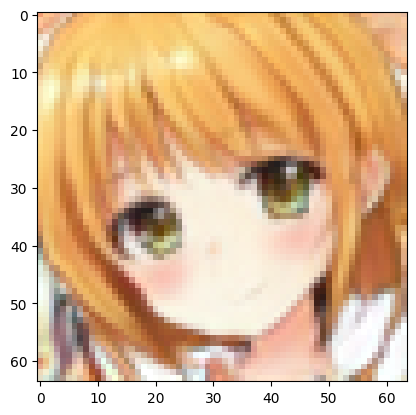

In [21]:
#參考資料: https://github.com/lucidrains/stylegan2-pytorch
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = './',   # path to where you invoked the command line tool
    name = 'stylegan2'                             # the project name, defaults to 'default'
)


noise   = torch.randn(1, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.75)  # pass through mapping network


images   = loader.styles_to_images(styles[:1])
test = torchvision.utils.make_grid(images.cpu(), nrow=10)

plt.imshow(test.permute(1, 2, 0))
plt.show()

In [25]:
os.makedirs('./output/', exist_ok=True)

for i in range(1000):
    noise   = torch.randn(1, 512) # noise
    styles  = loader.noise_to_styles(noise, trunc_psi = 0.75)  # pass through mapping network
    images  = loader.styles_to_images(styles[:1])
    save_image(images, f'./output/{i}.jpg')
    

In [26]:
# Compress the images.
%cd ./output
!tar -zcf ../submission_6000_752.tgz *.jpg
%cd ..

/home/ph/ML_2023/HW6test/output
/home/ph/ML_2023/HW6test
